## Load necessary libraries

In [ ]:
#!pip install SimpleITK
!pip install pytictoc
!pip install -U albumentations
#!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 102 kB 16.3 MB/s 
     |████████████████████████████████| 47.6 MB 37 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets,transforms, models
import torchvision.transforms.functional as TF
#from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from torchsummary import summary

import glob
import os 
from pathlib import Path
import random

from PIL import Image
import numpy as np
import pandas  as pd
import nibabel as nib
import matplotlib.pyplot as plt
from pytictoc import TicToc
import imageio
import cv2


from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle



# Load and Read Data

Data is in  png format : can be read using PIL library

Create function to reformat data slightly

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# store file names

mask_path = '/content/drive/MyDrive/A-SKIN_DATA/ISBI2016_ISIC_Part1_Training_GroundTruth'
file_path = '/content/drive/MyDrive/A-SKIN_DATA/ISBI2016_ISIC_Part1_Training_Data'

In [ ]:
# This is for storing filenames - better use
def read_datanames(givenData):
     '''
    Reads the slices and creates a list of tuples, containing one row per slice in the format [image, mask, slice number]
    '''
     total_data = []
     for idx, fn_mask in enumerate(givenData):

       # Actual Image
       fn_data = (fn_mask).replace('_Segmentation.png','.jpg')
       img_data = os.path.join(file_path, fn_data)

       # Mask Data read
       img_mask = os.path.join(mask_path, fn_mask)

       total_data += [(img_data, img_mask, fn_mask)]

     return total_data


  ### Gives a list of the following:  [image_filename, mask_filename, subject number string] 

Split all the names of the mask and string accordingly. - Use this to access the respective files using the function written above

In [ ]:
#  Get the list of all the masks

filenames_mask = list(os.listdir(mask_path))
print(f'Total number of masks: {len(filenames_mask)}')

# Split into the training, validation and test splits using scikit-learn's train_test_split function. 
# Also, check to see how many are in each to make sure that it makes sense.
tt, test_filenames = train_test_split(filenames_mask, test_size = 0.2, random_state = 11)
train_filenames, val_filenames = train_test_split(tt, test_size = 0.2, random_state = 11) #we split the temporary variables in an 80/20 partition

print(f'Number of training data: {len(train_filenames)}')
print(f'Number of validation data: {len(val_filenames)}')
print(f'Number of test data: {len(test_filenames)}')


print(len(test_filenames))


with open('/content/drive/MyDrive/test_filenames.txt', 'w') as f:
    for fn in test_filenames:
        f.write(fn)
        f.write('\n')

Total number of masks: 1279
Number of training data: 818
Number of validation data: 205
Number of test data: 256
256


Store lists into respective training and testing datasets

In [ ]:
train_file_slices = read_datanames(train_filenames)
val_file_slices = read_datanames(val_filenames)
test_file_slices = read_datanames(test_filenames)

print(f'Number of training slices: {len(train_file_slices)}')
print(f'Number of validation slices: {len(val_file_slices)}')
print(f'Number of test slices: {len(test_file_slices)}')


train_file_slices[0]

Number of training slices: 818
Number of validation slices: 205
Number of test slices: 256


('/content/drive/MyDrive/A-SKIN_DATA/ISBI2016_ISIC_Part1_Training_Data/ISIC_0011173.jpg',
 '/content/drive/MyDrive/A-SKIN_DATA/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0011173_Segmentation.png',
 'ISIC_0011173_Segmentation.png')

#### Check how the data is present

In [ ]:
print(f'First few training items: ')
for tfs in train_file_slices[:2]:
    print(tfs)


#mask = imageio.imread(train_file_slices[0][1])>0
#print(type(mask))
#plt.imshow(mask), plt.colorbar()

First few training items: 
('/content/drive/MyDrive/A-SKIN_DATA/ISBI2016_ISIC_Part1_Training_Data/ISIC_0011173.jpg', '/content/drive/MyDrive/A-SKIN_DATA/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0011173_Segmentation.png', 'ISIC_0011173_Segmentation.png')
('/content/drive/MyDrive/A-SKIN_DATA/ISBI2016_ISIC_Part1_Training_Data/ISIC_0000233.jpg', '/content/drive/MyDrive/A-SKIN_DATA/ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000233_Segmentation.png', 'ISIC_0000233_Segmentation.png')


Try model on this set first - then use model for the full set


In [ ]:
# 
#train_file_slices = random.choices(train_file_slices,k= 500)
#val_file_slices = random.choices(val_file_slices, k=100)
#test_file_slices = random.choices(test_file_slices, k=100)

Text(0.5, 1.0, 'Skin Lesion Mask')

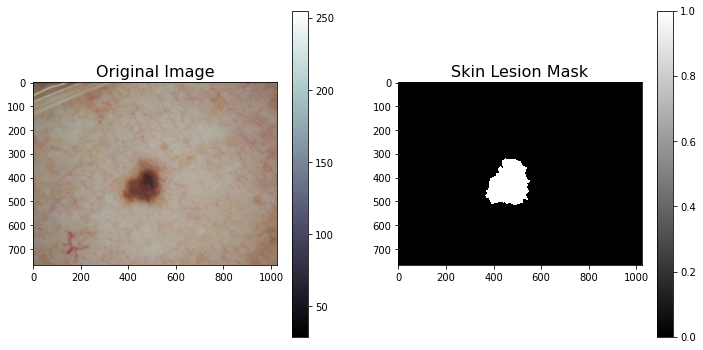

In [ ]:
# Get the filenames and slice from the structure
fn, fn_mask, sl = train_file_slices[0]

# Load the data using the loading function that will be used later
sample_skin = imageio.imread(fn)
sample_mask = imageio.imread(fn_mask)>0

# Plot the data, and make it look nice, you will probably use this in a paper
fig = plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(sample_skin, cmap='bone')
plt.colorbar()
plt.title('Original Image', fontsize=16)

plt.subplot(1,2,2)
plt.imshow(sample_mask, interpolation='none',cmap = 'gray')
plt.colorbar()
plt.title('Skin Lesion Mask', fontsize=16)

Define Batch Size and number of epochs

Enable GPU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'Device is {device}')

if device == 'cuda':
    print(f'CUDA device {torch.cuda.device(0)}')
    print(f'Number of devices: {torch.cuda.device_count()}')
    print(f'Device name: {torch.cuda.get_device_name(0)}')


Device is cpu


In [ ]:
#
# Transformtions to be applied to the training set - This is using Albumentations
#

train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.Rotate(limit=10, p=0.5),
        A.Resize(128, 128), # Why?
        #albumentations.pytorch.transforms.ToTensorV2(), # Why?
        A.pytorch.transforms.ToTensorV2()
    ]
)

In [ ]:
#
# Transformtions to be applied to the validation and testing sets - this is using Albumentations
#

test_transform = A.Compose(
    [
        A.Resize(128, 128), # need (128,128)
        A.pytorch.transforms.ToTensorV2()
        ]
)

In [ ]:
#
# Create the Dataset clas specific for this work.
#

class SkinDataset(Dataset):
    
    def __init__(self, filename_slices, transform):
        """
        Initialized
        """
        super().__init__()

        # Store variables we are interested in...
        self._filename_slices = filename_slices 
        self._transform = transform    

    def __getitem__(self, index):

        """
        Get a single image / label pair.
        """
        #
        # Read in the image
        #

        fn, fn_mask, sl = self._filename_slices[index]
        
        image = imageio.imread(fn).astype(np.float32)
        
        #
        # Read in the mask
        #
        mask = imageio.imread(fn_mask)>0
        mask = mask.astype(np.int8)
        
        #
        #  Can do further processing here or anything else
        #

        #
        # Data augmentation 
        #
        if self._transform is not None:
            augmented = self._transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            #image.cuda()
            #mask.cuda()
               
        #
        # Return the image mask pair
        
        
        return image, mask
    
    def __len__(self):
        """
        Return length of the dataset
        """
        return len(self._filename_slices)

In [ ]:
# Create the datsets and dataloaders for every subset 

train_dataset = SkinDataset(train_file_slices, train_transform)
val_dataset = SkinDataset(val_file_slices, test_transform)
test_dataset = SkinDataset(test_file_slices, test_transform)



In [ ]:
# Specify operations for batch size and epochs
batch_size = 25 #10
epochs = 20 #40

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False) 
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=False) 

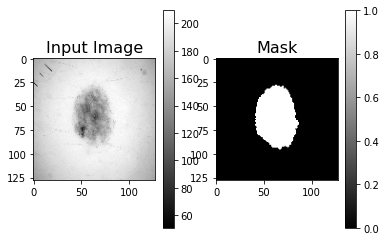

In [ ]:
image, mask = next(iter(train_dataloader)) 
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image[1,0]) # change x and y axis
plt.title('Input Image', fontsize=16)
plt.gray()
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(mask[1])
plt.title('Mask', fontsize=16)
plt.colorbar()

### Create a U-net architecture definition

In [ ]:
class contracting(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.ReLU())

        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, stride=1, padding=1), nn.ReLU())

        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, stride=1, padding=1), nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(256, 512, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(512, 512, 3, stride=1, padding=1), nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(512, 1024, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(1024, 1024, 3, stride=1, padding=1), nn.ReLU())

        self.down_sample = nn.MaxPool2d(2, stride=2)


    def forward(self, X):
        X1 = self.layer1(X)
        X2 = self.layer2(self.down_sample(X1))
        X3 = self.layer3(self.down_sample(X2))
        X4 = self.layer4(self.down_sample(X3))
        X5 = self.layer5(self.down_sample(X4))
        return X5, X4, X3, X2, X1


class expansive(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Conv2d(64, 2, 3, stride=1, padding=1)

        self.layer2 = nn.Sequential(nn.Conv2d(128, 64, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.ReLU())

        self.layer3 = nn.Sequential(nn.Conv2d(256, 128, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, stride=1, padding=1), nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(512, 256, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, stride=1, padding=1), nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(1024, 512, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(512, 512, 3, stride=1, padding=1), nn.ReLU())

        self.up_sample_54 = nn.ConvTranspose2d(1024, 512, 2, stride=2)

        self.up_sample_43 = nn.ConvTranspose2d(512, 256, 2, stride=2)

        self.up_sample_32 = nn.ConvTranspose2d(256, 128, 2, stride=2)

        self.up_sample_21 = nn.ConvTranspose2d(128, 64, 2, stride=2)


    def forward(self, X5, X4, X3, X2, X1):
        X = self.up_sample_54(X5)
        X4 = torch.cat([X, X4], dim=1)
        X4 = self.layer5(X4)

        X = self.up_sample_43(X4)
        X3 = torch.cat([X, X3], dim=1)
        X3 = self.layer4(X3)

        X = self.up_sample_32(X3)
        X2 = torch.cat([X, X2], dim=1)
        X2 = self.layer3(X2)

        X = self.up_sample_21(X2)
        X1 = torch.cat([X, X1], dim=1)
        X1 = self.layer2(X1)

        X = self.layer1(X1)

        return X


class unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.down = contracting()
        
        # Decoder
        self.up = expansive()

    def forward(self, X):
        # Encoder
        X5, X4, X3, X2, X1 = self.down(X)
        
        # Decoder
        X = self.up(X5, X4, X3, X2, X1)
        return X
        #F.softmax(X, dim=1)

### Specify model, optimizer, loss to put into function

In [ ]:
#
# Load the model

model = unet()
model.to(device) # this was previously commented

# Specify a path
#PATH = "/content/drive/MyDrive/unet_model.pt"

# Save
#torch.save(model.state_dict(), PATH)


# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create the loss function
loss = torch.nn.CrossEntropyLoss()

### Dice Score for accuracy

In [ ]:
def dice_coef(y_true, y_pred):
#     """
#     Compute the Dice coefficient between two N-D masks.
#     """

     # Convert the input to a numpy array if it is a torch Tensor
     if isinstance(y_true, torch.Tensor):
         y_true = y_true.cpu().detach().numpy()
    
     if isinstance(y_pred, torch.Tensor):
         y_pred = y_pred.cpu().detach().numpy()
    
     y_true_f = y_true.flatten()
     y_pred_f = y_pred.flatten()
     intersection = np.sum(y_true_f * y_pred_f)
     smooth = 0.0001
     return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))


# def dice_coef(ground_truth,segmented_mask ):
#   # USAGE:
#   # Both input arguments need to be numpy arrays
  
#   # Convert the input to a numpy array if it is a torch Tensor
#   if isinstance(segmented_mask, torch.Tensor):
#     segmented_mask = segmented_mask.cpu().detach().numpy()
    
#   if isinstance(ground_truth, torch.Tensor):
#     ground_truth = ground_truth.cpu().detach().numpy()

#   # if ground truth image white pixels are defined as 255, coerce to 1
#   ground_truth[ground_truth==255] = 1

#   # calculate IoU
#   area_of_overlap = np.zeros_like(ground_truth)
#   for j in range(ground_truth.shape[0]):
#     for k in range(ground_truth.shape[1]):
#       if segmented_mask[j,k] == 1 & ground_truth[j,k] == 1:
#         area_of_overlap[j,k] = 1
#       else:
#         area_of_overlap[j,k] = 0;
  
#   # xor(img_mask, ground truth) is equivalent to finding non overlapping parts, then adding area of overlap gives the union
#   area_of_union = np.add((np.array(segmented_mask, dtype=bool) ^ np.array(ground_truth, dtype=bool)),np.array(area_of_overlap, dtype=bool)).astype(int).sum()

#   IoU = area_of_overlap.sum() / area_of_union

#   DC = (2 * area_of_overlap.sum()) / (img_mask.sum() + np.array(gt, dtype=bool).sum())

#   return DC

Epoch 0 / 20


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


	Batch 0 loss 0.736
	Batch 1 loss 0.589
	Batch 2 loss 0.588
	Batch 3 loss 0.586
	Batch 4 loss 0.564
	Batch 5 loss 0.475
	Batch 6 loss 0.544
	Batch 7 loss 0.520
	Batch 8 loss 0.509
	Batch 9 loss 0.416
	Batch 10 loss 0.379
	Batch 11 loss 0.554
	Batch 12 loss 0.317
	Batch 13 loss 0.430
	Batch 14 loss 0.374
	Batch 15 loss 0.429
	Batch 16 loss 0.459
	Batch 17 loss 0.440
	Batch 18 loss 0.491
	Batch 19 loss 0.381
	Batch 20 loss 0.455
	Batch 21 loss 0.392
	Batch 22 loss 0.346
	Batch 23 loss 0.419
	Batch 24 loss 0.344
	Batch 25 loss 0.455
	Batch 26 loss 0.614
	Batch 27 loss 0.551
	Batch 28 loss 0.412
	Batch 29 loss 0.400
	Batch 30 loss 0.434
	Batch 31 loss 0.378
	Batch 32 loss 0.412
Loss: 0.467, Accuracy: 0.493
	Batch  0 0.5292567014694214


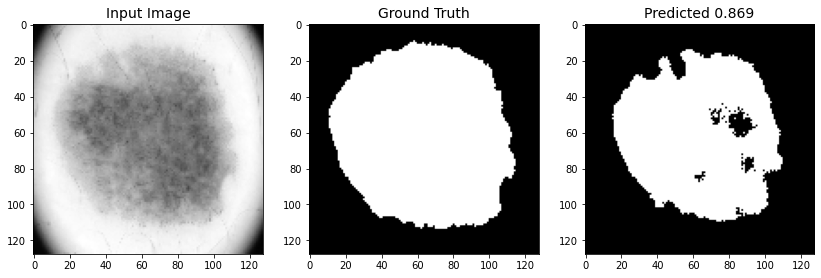

	Batch  1 0.41419586539268494
	Batch  2 0.369388610124588
	Batch  3 0.35614609718322754
	Batch  4 0.36488795280456543
	Batch  5 0.470510333776474
	Batch  6 0.40863272547721863
	Batch  7 0.4255361557006836
	Batch  8 0.33761799335479736
Validation Loss: 0.415, Accuracy: 0.571
Epoch 1 / 20
	Batch 0 loss 0.341
	Batch 1 loss 0.423
	Batch 2 loss 0.459
	Batch 3 loss 0.529
	Batch 4 loss 0.358
	Batch 5 loss 0.422
	Batch 6 loss 0.383
	Batch 7 loss 0.443
	Batch 8 loss 0.492
	Batch 9 loss 0.468
	Batch 10 loss 0.412
	Batch 11 loss 0.384
	Batch 12 loss 0.424
	Batch 13 loss 0.355
	Batch 14 loss 0.388
	Batch 15 loss 0.362
	Batch 16 loss 0.336
	Batch 17 loss 0.326
	Batch 18 loss 0.431
	Batch 19 loss 0.400
	Batch 20 loss 0.364
	Batch 21 loss 0.497
	Batch 22 loss 0.383
	Batch 23 loss 0.388
	Batch 24 loss 0.481
	Batch 25 loss 0.248
	Batch 26 loss 0.373
	Batch 27 loss 0.515
	Batch 28 loss 0.312
	Batch 29 loss 0.382
	Batch 30 loss 0.412
	Batch 31 loss 0.411
	Batch 32 loss 0.448
Loss: 0.404, Accuracy: 0.624


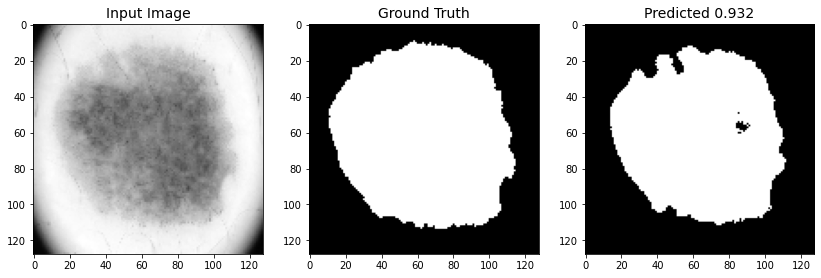

	Batch  1 0.41735419631004333
	Batch  2 0.3716447949409485
	Batch  3 0.33269527554512024
	Batch  4 0.3522959053516388
	Batch  5 0.4139852821826935
	Batch  6 0.35529887676239014
	Batch  7 0.4119272232055664
	Batch  8 0.37420833110809326
Validation Loss: 0.388, Accuracy: 0.666
Epoch 2 / 20
	Batch 0 loss 0.369
	Batch 1 loss 0.364
	Batch 2 loss 0.379
	Batch 3 loss 0.349
	Batch 4 loss 0.260
	Batch 5 loss 0.283
	Batch 6 loss 0.378
	Batch 7 loss 0.531
	Batch 8 loss 0.399
	Batch 9 loss 0.378
	Batch 10 loss 0.495
	Batch 11 loss 0.502
	Batch 12 loss 0.492
	Batch 13 loss 0.364
	Batch 14 loss 0.399
	Batch 15 loss 0.263
	Batch 16 loss 0.557
	Batch 17 loss 0.547
	Batch 18 loss 0.345
	Batch 19 loss 0.341
	Batch 20 loss 0.362
	Batch 21 loss 0.415
	Batch 22 loss 0.328
	Batch 23 loss 0.421
	Batch 24 loss 0.412
	Batch 25 loss 0.385
	Batch 26 loss 0.382
	Batch 27 loss 0.343
	Batch 28 loss 0.363
	Batch 29 loss 0.363
	Batch 30 loss 0.376
	Batch 31 loss 0.476
	Batch 32 loss 0.382
Loss: 0.394, Accuracy: 0.638

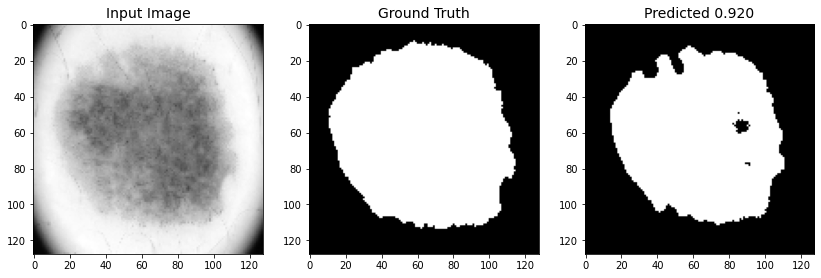

	Batch  1 0.3982661962509155
	Batch  2 0.35639727115631104
	Batch  3 0.3299865424633026
	Batch  4 0.33636391162872314
	Batch  5 0.4235492944717407
	Batch  6 0.3531174063682556
	Batch  7 0.40300238132476807
	Batch  8 0.3604280948638916
Validation Loss: 0.383, Accuracy: 0.649
Epoch 3 / 20
	Batch 0 loss 0.341
	Batch 1 loss 0.341
	Batch 2 loss 0.407
	Batch 3 loss 0.387
	Batch 4 loss 0.318
	Batch 5 loss 0.541
	Batch 6 loss 0.372
	Batch 7 loss 0.411
	Batch 8 loss 0.432
	Batch 9 loss 0.390
	Batch 10 loss 0.458
	Batch 11 loss 0.369
	Batch 12 loss 0.409
	Batch 13 loss 0.347
	Batch 14 loss 0.427
	Batch 15 loss 0.349
	Batch 16 loss 0.351
	Batch 17 loss 0.342
	Batch 18 loss 0.376
	Batch 19 loss 0.408
	Batch 20 loss 0.436
	Batch 21 loss 0.376
	Batch 22 loss 0.381
	Batch 23 loss 0.432
	Batch 24 loss 0.370
	Batch 25 loss 0.263
	Batch 26 loss 0.387
	Batch 27 loss 0.290
	Batch 28 loss 0.293
	Batch 29 loss 0.317
	Batch 30 loss 0.294
	Batch 31 loss 0.405
	Batch 32 loss 0.354
Loss: 0.375, Accuracy: 0.667


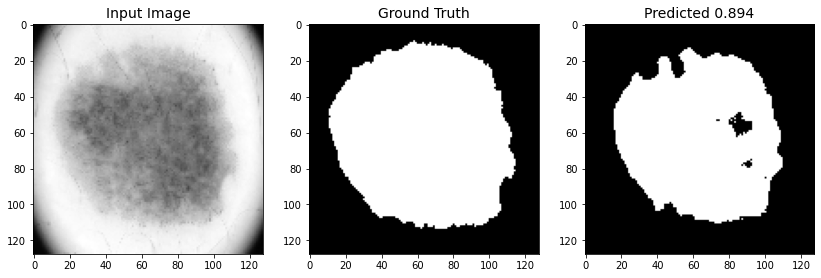

	Batch  1 0.3737039864063263
	Batch  2 0.3341272473335266
	Batch  3 0.3378024995326996
	Batch  4 0.3176287114620209
	Batch  5 0.47353512048721313
	Batch  6 0.36135223507881165
	Batch  7 0.4059855341911316
	Batch  8 0.27997761964797974
Validation Loss: 0.388, Accuracy: 0.618
Epoch 4 / 20
	Batch 0 loss 0.473
	Batch 1 loss 0.301
	Batch 2 loss 0.418
	Batch 3 loss 0.334
	Batch 4 loss 0.421
	Batch 5 loss 0.344
	Batch 6 loss 0.410
	Batch 7 loss 0.275
	Batch 8 loss 0.298
	Batch 9 loss 0.267
	Batch 10 loss 0.354
	Batch 11 loss 0.275
	Batch 12 loss 0.425
	Batch 13 loss 0.329
	Batch 14 loss 0.349


In [ ]:
train_accuracy = []
train_loss = []

validation_accuracy = []
validation_loss = []

best_accuracy = 0

for epoch in range(epochs):
 
    #
    # Training Loop
    #

    print('='*30)
    print('Epoch {} / {}'.format(epoch, epochs))
    
    # Set variables - initialize
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_counter = 0
    
    model.train()

    # Batch Training Loop (Loop over the batches)
    for index, (X, Y) in enumerate(train_dataloader):
        
        if device is not None:
            X = X.to(device)
            Y = Y.to(device)

        # Call the model (image to mask)
        R = model(X)
        
        # Compute the loss
        L = loss(R, Y.long())

        # Do PyTorch stuff - Training 
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        
        pred = R.data.max(1)[1]
        
        # Analyze the accuracy of the batch 
        epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
        epoch_loss += L.data.item() * X.shape[0]
        print(f'\tBatch {index} loss {L.data.item():3.3f}')
        
        epoch_counter += X.shape[0]
  
    # Epoch Train Loss
    train_accuracy.append(epoch_accuracy/epoch_counter)
    train_loss.append(epoch_loss/epoch_counter)
    print(f"Loss: {train_loss[-1]:3.3f}, Accuracy: {train_accuracy[-1]:3.3f}")
    
    #
    # Validation Loop 
    #
   
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_counter = 0
    
    model.eval()
    
    # Batch Validation Loop (Loop over the batches)
    with torch.no_grad():
        for index, (X, Y) in enumerate(val_dataloader):

            if device is not None:
                X = X.to(device)
                Y = Y.to(device)

            # Call the model (image to mask)
            R = model(X)

            # Compute the loss
            L = loss(R, Y.long())

            pred = R.data.max(1)[1]

            # Analyze the accuracy of the batch 
            epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
            epoch_loss += L.data.item() * X.shape[0]
            print('\tBatch ', index, L.data.item())

            
            if epoch_accuracy > best_accuracy:
              torch.save(model.state_dict(),"/content/drive/MyDrive/unet_best_model.pt")
              best_accuracy = epoch_accuracy


            if index == 0:
                plt.figure(figsize=[14, 7])
                plt.subplot(1,3,1)
                plt.imshow(X[0, 0].cpu().detach().numpy())
                plt.title('Input Image', fontsize=14)
                plt.subplot(1,3,2)
                plt.imshow(Y[0].cpu().detach().numpy())
                plt.title('Ground Truth', fontsize=14)
                plt.subplot(1,3,3)
                plt.imshow(pred[0].cpu().detach().numpy())
                plt.title(f'Predicted {dice_coef(pred[0], Y[0]):3.3f}', fontsize=14)
                plt.show()

            epoch_counter += X.shape[0]

    # Epoch Train Loss
    validation_accuracy.append(epoch_accuracy/epoch_counter)
    validation_loss.append(epoch_loss/epoch_counter)
    print(f"Validation Loss: {validation_loss[-1]:3.3f}, Accuracy: {validation_accuracy[-1]:3.3f}")

### Figures and Display

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/unet_best_model.pt"))
model.eval()

# Display Train and Validation Loss and Dice scores

fig = plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Train and Validation Loss', fontsize=16)
plt.xticks(range(epochs))
plt.grid('on')
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.plot(train_accuracy,label='Training')
plt.plot(validation_accuracy,label='Validation')
plt.xticks(range(epochs))
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Train and Validation Accuracy', fontsize=16)
plt.grid('on')
plt.legend(fontsize=14)

### Run on testing data

In [ ]:
model.eval()

test_accuracy = []
test_loss = []
epoch_accuracy = 0
epoch_counter = 0
test_images = []

#model.load_state_dict(torch.load("/content/drive/MyDrive/unet_best_model.pt"))
model.eval()

with torch.no_grad():
    # Batch Validation Loop (Loop over the batches)
    for index, (X, Y) in enumerate(test_dataloader):

        if device is not None:
            X = X.to(device)
            Y = Y.to(device)

        # Call the model (image to mask)
        R = model(X)

        pred = R.data.max(1)[1]

        # Analyze the accuracy of the batch 
        epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
        epoch_counter += X.shape[0]

        #
        # Display the first image, mask and predicted of the batch
        #
        plt.figure(figsize=[14, 7])
        plt.subplot(1,3,1)
        plt.imshow(X[0, 0].cpu().detach().numpy())
        plt.title('Input Image', fontsize=14)
        plt.subplot(1,3,2)
        plt.imshow(Y[0].cpu().detach().numpy())
        plt.title('Ground Truth', fontsize=14)
        plt.subplot(1,3,3)
        plt.imshow(pred[0].cpu().detach().numpy())
        plt.title(f'Predicted {dice_coef(pred[0], Y[0]):3.3f}', fontsize=14)
        plt.show()
        
        # Epoch Train Loss
        test_images.append(pred)
        test_accuracy.append(epoch_accuracy/epoch_counter)
        test_loss.append(epoch_loss/epoch_counter)
        print(f"Test Accuracy: {test_accuracy[-1]:3.3f}")
        #print(test_accuracy)

In [ ]:
np.savetxt('/content/drive/MyDrive/test_accuracy.txt',test_accuracy)

In [ ]:
model.eval()

test_accuracy = []
test_loss = []
epoch_accuracy = 0
epoch_counter = 0
test_images = []
og_im = []
og_mask = []
#model.load_state_dict(torch.load("/content/drive/MyDrive/unet_best_model.pt"))
model.eval()

with torch.no_grad():
    # Batch Validation Loop (Loop over the batches)
    for index, (X, Y) in enumerate(test_dataloader):

        if device is not None:
            X = X.to(device)
            Y = Y.to(device)

        # Call the model (image to mask)
        R = model(X)

        pred = R.data.max(1)[1]

        # Analyze the accuracy of the batch 
        epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
        epoch_counter += X.shape[0]

        #
        # Display the first image, mask and predicted of the batch
        #
        plt.figure(figsize=[18, 6])
        plt.suptitle(test_filenames[index], fontsize = 16)
        plt.subplot(1,3,1)
        plt.imshow(X[0, 0].cpu().detach().numpy()),plt.colorbar(fraction=0.046, pad=0.04)
        plt.title('Input Image', fontsize=14)
        plt.subplot(1,3,2)
        plt.imshow(Y[0].cpu().detach().numpy())
        plt.title('Ground Truth', fontsize=14)
        plt.subplot(1,3,3)
        plt.imshow(pred[0].cpu().detach().numpy())
        plt.title(f'Predicted {dice_coef(pred[0], Y[0]):3.3f}', fontsize=14)
        plt.show()
        
        # Epoch Train Loss
        og_im.append(X)
        og_mask.append(Y)
        test_images.append(pred)
        test_accuracy.append(epoch_accuracy/epoch_counter)
        test_loss.append(epoch_loss/epoch_counter)
        print(f"Test Accuracy: {test_accuracy[-1]:3.3f}")
        #print(test_accuracy)

In [ ]:
def IoU_DC_calc(segmented_mask, ground_truth):
  # USAGE:
  # Both input arguments need to be numpy arrays
  
  # if ground truth image white pixels are defined as 255, coerce to 1
  ground_truth[ground_truth==255] = 1

  # calculate IoU
  area_of_overlap = np.zeros_like(ground_truth)
  for j in range(ground_truth.shape[0]):
    for k in range(ground_truth.shape[1]):
      if segmented_mask[j,k] == 1 & ground_truth[j,k] == 1:
        area_of_overlap[j,k] = 1
      else:
        area_of_overlap[j,k] = 0;
  
  # xor(img_mask, ground truth) is equivalent to finding non overlapping parts, then adding area of overlap gives the union
  area_of_union = np.add((np.array(segmented_mask, dtype=bool) ^ np.array(ground_truth, dtype=bool)),np.array(area_of_overlap, dtype=bool)).astype(int).sum()

  IoU = area_of_overlap.sum() / area_of_union

  DC = (2 * area_of_overlap.sum()) / (img_mask.sum() + np.array(gt, dtype=bool).sum())

  return IoU, DC

In [ ]:
actual_image = []
im = (128,128)
arrays = np.arange(0, 256, 1)
for x in arrays:
  new_image = imageio.imread(test_file_slices[x][1])>0
  new_image = im.resize(im)
  new_image = new_image.astype(np.int8)
  actual_image.append(new_image)


In [ ]:
IoU_DC_calc(test_images[0],actual_image[0])